# Deep learning

In [1]:
%load_ext autoreload
%autoreload 2

import lib.data
import lib.torch_train_eval
import lib.adaptive_train_eval

import tasks.preprocessing
import tasks.utils
import tasks.results

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

import random
import os


DATA_DIR = "data/office"
OUTPUT_DIR = "output"

SOURCE_DATASET = "amazon"
SOURCE_VAL_SPLIT = .15
SOURCE_TEST_SPLIT = .1

TARGET_VAL_SPLIT = .15
TARGET_TEST_SPLIT = .15
TARGET_DATASET = "webcam"

FINETUNED_MODEL_DIR = os.path.join(OUTPUT_DIR, "classifier")
UNSUPERVISED_MODEL_DIR = os.path.join(OUTPUT_DIR, "unsupervised")
SEMI_SUPERVISED_FINETUNED_MODEL_DIR = os.path.join(OUTPUT_DIR, "semi-supervised-finetuned")
SEMI_SUPERVISED_ADAPTIVE_MODEL_DIR = os.path.join(OUTPUT_DIR, "semi-supervised-adaptive")

FINETUNE_MODEL = False
TRAIN_UNSUPERVISED_MODEL = True
FINETUNE_SEMI_SUPERVISED_MODEL = False
TRAIN_SEMI_SUPERVISED_MODEL = False

RANDOM_SEED = 42
BATCH_SIZE = 2

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Modern Office Dataset

In [2]:
source_dataset = lib.data.ImageDataset(
    parser_func=tasks.preprocessing.image_read_func,
    preprocessing_func=tasks.preprocessing.resnet_preprocessor,
)
source_dataset.load_from_directory(os.path.join(DATA_DIR, SOURCE_DATASET))

source_train_dataset, source_val_dataset, source_test_dataset = (
    lib.data.train_val_test_split(
        source_dataset, SOURCE_VAL_SPLIT, SOURCE_TEST_SPLIT
    )
)

  0%|          | 0/31 [00:00<?, ?it/s]

In [3]:
source_train_loader = tasks.preprocessing.create_padded_dataloader(
    source_train_dataset, shuffle=True, batch_size=BATCH_SIZE
)
source_val_loader = tasks.preprocessing.create_padded_dataloader(
    source_val_dataset, shuffle=False, batch_size=BATCH_SIZE
)
source_test_loader = tasks.preprocessing.create_padded_dataloader(
    source_test_dataset, shuffle=False, batch_size=BATCH_SIZE
)

In [4]:
target_dataset = lib.data.ImageDataset(
    parser_func=tasks.preprocessing.image_read_func,
    preprocessing_func=tasks.preprocessing.resnet_preprocessor,
    label_encoder=source_dataset.label_encoder,  # use same classes
)
target_dataset.load_from_directory(os.path.join(DATA_DIR, TARGET_DATASET))

target_train_dataset, target_val_dataset, target_test_dataset = (
    lib.data.train_val_test_split(
        target_dataset, TARGET_VAL_SPLIT, TARGET_TEST_SPLIT
    )
)

target_train_loader = tasks.preprocessing.create_padded_dataloader(
    target_train_dataset, shuffle=True, batch_size=BATCH_SIZE
)
target_test_loader = tasks.preprocessing.create_padded_dataloader(
    target_test_dataset, shuffle=False, batch_size=BATCH_SIZE
)

  0%|          | 0/31 [00:00<?, ?it/s]

In [5]:
unlabeled_dataset = lib.data.UnlabeledImageDataset(
    parser_func=tasks.preprocessing.image_read_func,
    preprocessing_func=tasks.preprocessing.resnet_preprocessor,
)
unlabeled_dataset.load_from_image_dataset(target_train_dataset)

source_history = tasks.utils.try_load_history(
    os.path.join(UNSUPERVISED_MODEL_DIR, "source_history.pickle")
)
target_history = tasks.utils.try_load_history(
    os.path.join(UNSUPERVISED_MODEL_DIR, "target_history.pickle")
)

In [6]:
to_be_unlabeled_dataset, labeled_dataset = lib.data.stratified_split(
    target_train_dataset, test_size=0.2
)

len(unlabeled_dataset), len(labeled_dataset), len(target_train_dataset)

(556, 112, 556)

In [7]:
unlabeled_dataset = lib.data.UnlabeledImageDataset(
    parser_func=labeled_dataset.parser_func,
    preprocessing_func=labeled_dataset.preprocessing_func,
)
unlabeled_dataset.load_from_image_dataset(to_be_unlabeled_dataset)

# combine data from both domain and target datasets
for sample_img, sample_label in source_train_dataset.samples:
    labeled_dataset.add(sample_img, sample_label)

len(labeled_dataset), len(source_train_dataset)

(2224, 2112)

In [15]:
class_names = source_train_dataset.label_encoder.classes_

encodings = {
    label: class_name
    for label, class_name in enumerate(source_train_dataset.label_encoder.classes_)
}

## Source-only model

In [9]:
import torchinfo

def get_default_model():
    return torch.hub.load(
        "pytorch/vision:v0.10.0", "resnet18", weights="DEFAULT"
    ).to(device)

model = get_default_model()

torchinfo.summary(model, input_size=(BATCH_SIZE, 3, 300, 300))

Using cache found in /home/dimits/.cache/torch/hub/pytorch_vision_v0.10.0


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [2, 1000]                 --
├─Conv2d: 1-1                            [2, 64, 150, 150]         9,408
├─BatchNorm2d: 1-2                       [2, 64, 150, 150]         128
├─ReLU: 1-3                              [2, 64, 150, 150]         --
├─MaxPool2d: 1-4                         [2, 64, 75, 75]           --
├─Sequential: 1-5                        [2, 64, 75, 75]           --
│    └─BasicBlock: 2-1                   [2, 64, 75, 75]           --
│    │    └─Conv2d: 3-1                  [2, 64, 75, 75]           36,864
│    │    └─BatchNorm2d: 3-2             [2, 64, 75, 75]           128
│    │    └─ReLU: 3-3                    [2, 64, 75, 75]           --
│    │    └─Conv2d: 3-4                  [2, 64, 75, 75]           36,864
│    │    └─BatchNorm2d: 3-5             [2, 64, 75, 75]           128
│    │    └─ReLU: 3-6                    [2, 64, 75, 75]           --
│

In [10]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer_ft = optim.Adam(model.parameters(), lr=0.0005)
# disable lr for adam
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=100000, gamma=0.05)

In [ ]:
history = tasks.utils.try_load_history(os.path.join(FINETUNED_MODEL_DIR, "history.pickle"))

if FINETUNE_MODEL:
    model, history = lib.torch_train_eval.train_model(
        model,
        criterion,
        optimizer_ft,
        exp_lr_scheduler,
        device,
        source_train_loader,
        source_val_loader,
        output_dir=FINETUNED_MODEL_DIR,
        num_epochs=1,
        patience=5,
        warmup_period=1,
        previous_history=history
    )

model = tasks.utils.try_load_weights(model, os.path.join(FINETUNED_MODEL_DIR, "model.pt"))

In [ ]:
plt.plot(np.array(range(len(history["train_loss"]))), history["train_loss"])
plt.plot(np.array(range(len(history["val_loss"]))), history["val_loss"])
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy Loss")
plt.title("Training loss")
plt.show()

In [ ]:
# validation accuracy has been calculated wrong here, ignore it for now
plt.plot(np.array(range(len(history["train_acc"]))), history["train_acc"])
plt.plot(np.array(range(len(history["val_acc"]))), history["val_acc"])

plt.xlabel("Epoch")
plt.ylabel("Cross Entropy Loss")
plt.title("Training Accuracy")
plt.show()

In [ ]:
tasks.results.classification_results(model, source_test_loader, class_names, device)

In [ ]:
tasks.results.classification_results(model, target_test_loader, class_names, device)

## Unsupervised Domain Adaptation

https://webcache.googleusercontent.com/search?q=cache:https://towardsdatascience.com/pseudo-labeling-to-deal-with-small-datasets-what-why-how-fd6f903213af

https://stats.stackexchange.com/questions/364584/why-does-using-pseudo-labeling-non-trivially-affect-the-results

https://www.sciencedirect.com/science/article/abs/pii/S1077314222001102

In [11]:
model = tasks.utils.try_load_weights(model, os.path.join(FINETUNED_MODEL_DIR, "model.pt"))

In [12]:
if TRAIN_UNSUPERVISED_MODEL:
    model, source_history, target_history, label_history = (
        lib.adaptive_train_eval.train_adaptive_model(
            model=model,
            criterion=criterion,
            optimizer=optimizer_ft,
            scheduler=exp_lr_scheduler,
            device=device,
            source_train_dataset=labeled_dataset,
            source_val_dataset=source_val_dataset,
            labeled_dataloader_initializer=lambda dataset, sampler=None: tasks.preprocessing.create_padded_dataloader(
                dataset, sampler=sampler, batch_size=BATCH_SIZE
            ),
            unlabeled_dataloader_initializer=lambda dataset: torch.utils.data.DataLoader(
                dataset, batch_size=1, shuffle=True
            ),
            unlabeled_target_train_dataset=unlabeled_dataset,
            target_val_dataset=target_val_dataset,
            output_dir=UNSUPERVISED_MODEL_DIR,
            num_epochs=160,
            pseudo_sample_period=20,
            rho=3,
            previous_source_history=source_history,
            previous_target_history=target_history,
        )
    )

model = tasks.utils.try_load_weights(model, os.path.join(UNSUPERVISED_MODEL_DIR, "model.pt"))

Epoch 0/159
----------


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/444 [00:00<?, ?it/s]

/home/dimits/anaconda3/envs/tf/lib/python3.9/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Selected 14/444 images on threshold 0.924307775654186
[('data/office/webcam/phone/frame_0008.jpg', 20), ('data/office/webcam/phone/frame_0002.jpg', 20), ('data/office/webcam/phone/frame_0001.jpg', 20), ('data/office/webcam/calculator/frame_0018.jpg', 5), ('data/office/webcam/calculator/frame_0011.jpg', 5), ('data/office/webcam/phone/frame_0015.jpg', 20), ('data/office/webcam/bike_helmet/frame_0011.jpg', 2), ('data/office/webcam/keyboard/frame_0009.jpg', 11), ('data/office/webcam/phone/frame_0009.jpg', 20), ('data/office/webcam/stapler/frame_0018.jpg', 28), ('data/office/webcam/phone/frame_0012.jpg', 20), ('data/office/webcam/phone/frame_0016.jpg', 20), ('data/office/webcam/calculator/frame_0012.jpg', 5), ('data/office/webcam/phone/frame_0010.jpg', 20)]


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.8333 Val Acc: 0.1765
Epoch 1/159
----------


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.3308 Train Acc: 0.9286
Source dataset Val Loss: 2.3677 Val Acc: 0.7559



  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.8007 Val Acc: 0.1765
Epoch 2/159
----------


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.6748 Train Acc: 0.8571
Source dataset Val Loss: 2.2733 Val Acc: 0.7938



  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.6781 Val Acc: 0.1849
Epoch 3/159
----------


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.3689 Train Acc: 0.9286
Source dataset Val Loss: 2.1353 Val Acc: 0.7796



  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.5994 Val Acc: 0.1933
Epoch 4/159
----------


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.2080 Train Acc: 1.0000
Source dataset Val Loss: 2.3941 Val Acc: 0.8175



  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.5286 Val Acc: 0.2521
Epoch 5/159
----------


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.4993 Train Acc: 0.9286
Source dataset Val Loss: 2.4215 Val Acc: 0.8104



  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.7106 Val Acc: 0.2017
Epoch 6/159
----------


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.1102 Train Acc: 1.0000
Source dataset Val Loss: 2.5817 Val Acc: 0.7867



  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.7272 Val Acc: 0.1681
Epoch 7/159
----------


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.6203 Train Acc: 0.8571
Source dataset Val Loss: 2.5298 Val Acc: 0.8128



  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.6402 Val Acc: 0.2689
Epoch 8/159
----------


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.5200 Train Acc: 0.8571
Source dataset Val Loss: 2.2799 Val Acc: 0.8033



  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.5385 Val Acc: 0.2521
Epoch 9/159
----------


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.4177 Train Acc: 0.9286
Source dataset Val Loss: 2.2466 Val Acc: 0.7938



  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.5424 Val Acc: 0.2689
Epoch 10/159
----------


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.6074 Train Acc: 0.8571
Source dataset Val Loss: 2.1648 Val Acc: 0.8318



  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.5926 Val Acc: 0.2437
Epoch 11/159
----------


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.3278 Train Acc: 0.9286
Source dataset Val Loss: 2.2965 Val Acc: 0.8033



  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.6054 Val Acc: 0.2101
Epoch 12/159
----------


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.3516 Train Acc: 0.9286
Source dataset Val Loss: 2.3203 Val Acc: 0.7749



  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.5966 Val Acc: 0.2437
Epoch 13/159
----------


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.5401 Train Acc: 0.9286
Source dataset Val Loss: 2.1887 Val Acc: 0.7725



  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.6759 Val Acc: 0.1849
Epoch 14/159
----------


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.5856 Train Acc: 0.8571
Source dataset Val Loss: 2.1492 Val Acc: 0.7844



  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.6804 Val Acc: 0.1849
Epoch 15/159
----------


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.3198 Train Acc: 1.0000
Source dataset Val Loss: 2.2835 Val Acc: 0.7867



  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.6584 Val Acc: 0.1933
Epoch 16/159
----------


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.5050 Train Acc: 0.8571
Source dataset Val Loss: 2.2352 Val Acc: 0.8341



  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.5740 Val Acc: 0.2017
Epoch 17/159
----------


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.5288 Train Acc: 0.9286
Source dataset Val Loss: 2.2461 Val Acc: 0.8033



  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.6357 Val Acc: 0.2269
Epoch 18/159
----------


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.1327 Train Acc: 1.0000
Source dataset Val Loss: 2.3538 Val Acc: 0.8246



  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.5925 Val Acc: 0.2689
Epoch 19/159
----------


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.4726 Train Acc: 0.8571
Source dataset Val Loss: 2.3237 Val Acc: 0.7725



  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.6131 Val Acc: 0.2269
Epoch 20/159
----------


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.1265 Train Acc: 1.0000
Source dataset Val Loss: 2.2652 Val Acc: 0.7701



  0%|          | 0/430 [00:00<?, ?it/s]

Selected 9/430 images on threshold 0.9097368870659647
[('data/office/webcam/calculator/frame_0024.jpg', 5), ('data/office/webcam/calculator/frame_0027.jpg', 5), ('data/office/webcam/desk_chair/frame_0039.jpg', 27), ('data/office/webcam/tape_dispenser/frame_0018.jpg', 29), ('data/office/webcam/calculator/frame_0020.jpg', 5), ('data/office/webcam/calculator/frame_0017.jpg', 5), ('data/office/webcam/calculator/frame_0026.jpg', 5), ('data/office/webcam/calculator/frame_0022.jpg', 5), ('data/office/webcam/monitor/frame_0007.jpg', 27)]


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.7339 Val Acc: 0.2101
Epoch 21/159
----------


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.2926 Train Acc: 0.9565
Source dataset Val Loss: 2.2332 Val Acc: 0.8081



  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.7592 Val Acc: 0.2017
Epoch 22/159
----------


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.3065 Train Acc: 0.9565
Source dataset Val Loss: 2.4297 Val Acc: 0.7370



  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.9478 Val Acc: 0.1933
Epoch 23/159
----------


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.2693 Train Acc: 1.0000
Source dataset Val Loss: 2.3978 Val Acc: 0.8341



  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.7433 Val Acc: 0.2521
Epoch 24/159
----------


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.4219 Train Acc: 0.9130
Source dataset Val Loss: 2.2622 Val Acc: 0.7583



  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.7894 Val Acc: 0.2185
Epoch 25/159
----------


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.3114 Train Acc: 0.9565
Source dataset Val Loss: 2.1728 Val Acc: 0.7820



  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.7116 Val Acc: 0.1933
Epoch 26/159
----------


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.4100 Train Acc: 0.9130
Source dataset Val Loss: 2.2544 Val Acc: 0.7630



  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.8193 Val Acc: 0.2353
Epoch 27/159
----------


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.3418 Train Acc: 1.0000
Source dataset Val Loss: 2.4972 Val Acc: 0.7986



  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.6394 Val Acc: 0.2521
Epoch 28/159
----------


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.2271 Train Acc: 1.0000
Source dataset Val Loss: 2.4972 Val Acc: 0.7867



  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.6362 Val Acc: 0.2605
Epoch 29/159
----------


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.3527 Train Acc: 0.9130
Source dataset Val Loss: 2.3726 Val Acc: 0.7654



  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.8616 Val Acc: 0.2101
Epoch 30/159
----------


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.1706 Train Acc: 1.0000
Source dataset Val Loss: 2.4657 Val Acc: 0.7630



  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.6586 Val Acc: 0.2353
Epoch 31/159
----------


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.3412 Train Acc: 0.9565
Source dataset Val Loss: 2.2957 Val Acc: 0.7630



  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.4653 Val Acc: 0.3277
Epoch 32/159
----------


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.1779 Train Acc: 1.0000
Source dataset Val Loss: 2.3498 Val Acc: 0.7962



  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.6509 Val Acc: 0.2437
Epoch 33/159
----------


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.2173 Train Acc: 1.0000
Source dataset Val Loss: 2.2945 Val Acc: 0.7867



  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.7653 Val Acc: 0.2101
Epoch 34/159
----------


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.2354 Train Acc: 1.0000
Source dataset Val Loss: 2.2846 Val Acc: 0.7488



  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.6783 Val Acc: 0.2521
Epoch 35/159
----------


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.2527 Train Acc: 0.9565
Source dataset Val Loss: 2.3312 Val Acc: 0.8057



  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.8902 Val Acc: 0.2101
Epoch 36/159
----------


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.2934 Train Acc: 0.9565
Source dataset Val Loss: 2.3968 Val Acc: 0.7180



  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.9970 Val Acc: 0.2101
Epoch 37/159
----------


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.3544 Train Acc: 0.9565
Source dataset Val Loss: 2.2723 Val Acc: 0.7393



  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.7221 Val Acc: 0.2353
Epoch 38/159
----------


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.2225 Train Acc: 1.0000
Source dataset Val Loss: 2.1736 Val Acc: 0.7938



  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.6241 Val Acc: 0.2353
Epoch 39/159
----------


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.4483 Train Acc: 0.9130
Source dataset Val Loss: 2.3473 Val Acc: 0.7867



  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.5939 Val Acc: 0.2017
Epoch 40/159
----------


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.3149 Train Acc: 0.9565
Source dataset Val Loss: 2.3650 Val Acc: 0.7607



  0%|          | 0/421 [00:00<?, ?it/s]

Selected 7/421 images on threshold 0.9073744780198288
[('data/office/webcam/projector/frame_0020.jpg', 22), ('data/office/webcam/calculator/frame_0001.jpg', 5), ('data/office/webcam/keyboard/frame_0012.jpg', 5), ('data/office/webcam/speaker/frame_0003.jpg', 27), ('data/office/webcam/keyboard/frame_0002.jpg', 5), ('data/office/webcam/speaker/frame_0002.jpg', 27), ('data/office/webcam/projector/frame_0019.jpg', 22)]


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.7353 Val Acc: 0.1933
Epoch 41/159
----------


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.3287 Train Acc: 0.9333
Source dataset Val Loss: 2.4712 Val Acc: 0.7820



  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.4335 Val Acc: 0.3277
Epoch 42/159
----------


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.3556 Train Acc: 0.9333
Source dataset Val Loss: 2.4981 Val Acc: 0.7867



  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.5863 Val Acc: 0.2521
Epoch 43/159
----------


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.3864 Train Acc: 0.9000
Source dataset Val Loss: 2.2866 Val Acc: 0.7417



  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.6092 Val Acc: 0.1681
Epoch 44/159
----------


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.3283 Train Acc: 0.9333
Source dataset Val Loss: 2.3304 Val Acc: 0.7275



  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.7065 Val Acc: 0.2101
Epoch 45/159
----------


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.3102 Train Acc: 0.9667
Source dataset Val Loss: 2.4049 Val Acc: 0.8128



  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.5347 Val Acc: 0.2605
Epoch 46/159
----------


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.3692 Train Acc: 0.9333
Source dataset Val Loss: 2.5350 Val Acc: 0.7536



  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.5760 Val Acc: 0.2941
Epoch 47/159
----------


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.1768 Train Acc: 1.0000
Source dataset Val Loss: 2.3644 Val Acc: 0.7820



  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.5902 Val Acc: 0.2773
Epoch 48/159
----------


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.5613 Train Acc: 0.9333
Source dataset Val Loss: 2.4624 Val Acc: 0.7322



  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.5054 Val Acc: 0.2521
Epoch 49/159
----------


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.2991 Train Acc: 0.9333
Source dataset Val Loss: 2.3620 Val Acc: 0.7417



  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.5548 Val Acc: 0.2689
Epoch 50/159
----------


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.1176 Train Acc: 1.0000
Source dataset Val Loss: 2.2899 Val Acc: 0.7488



  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.5114 Val Acc: 0.2521
Epoch 51/159
----------


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.1362 Train Acc: 1.0000
Source dataset Val Loss: 2.4991 Val Acc: 0.7488



  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.3459 Val Acc: 0.3193
Epoch 52/159
----------


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.2855 Train Acc: 0.9667
Source dataset Val Loss: 2.2860 Val Acc: 0.8104



  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.5022 Val Acc: 0.3109
Epoch 53/159
----------


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.2734 Train Acc: 0.9667
Source dataset Val Loss: 2.4162 Val Acc: 0.8081



  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.6806 Val Acc: 0.2437
Epoch 54/159
----------


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.3260 Train Acc: 0.9667
Source dataset Val Loss: 2.2482 Val Acc: 0.7583



  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.7316 Val Acc: 0.1849
Epoch 55/159
----------


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.3291 Train Acc: 0.9667
Source dataset Val Loss: 2.3480 Val Acc: 0.7962



  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.6258 Val Acc: 0.2605
Epoch 56/159
----------


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.1973 Train Acc: 1.0000
Source dataset Val Loss: 2.2968 Val Acc: 0.7488



  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.5453 Val Acc: 0.2857
Epoch 57/159
----------


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.4711 Train Acc: 0.9000
Source dataset Val Loss: 2.4116 Val Acc: 0.8033



  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.5145 Val Acc: 0.2941
Epoch 58/159
----------


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.3659 Train Acc: 0.9000
Source dataset Val Loss: 2.2994 Val Acc: 0.7986



  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.4450 Val Acc: 0.2857
Epoch 59/159
----------


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.2759 Train Acc: 0.9333
Source dataset Val Loss: 2.6115 Val Acc: 0.8436



  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.3914 Val Acc: 0.3025
Epoch 60/159
----------


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.2190 Train Acc: 0.9667
Source dataset Val Loss: 2.3186 Val Acc: 0.8104



  0%|          | 0/414 [00:00<?, ?it/s]

Selected 21/414 images on threshold 0.9191816426628732
[('data/office/webcam/mouse/frame_0017.jpg', 10), ('data/office/webcam/mouse/frame_0008.jpg', 26), ('data/office/webcam/headphones/frame_0018.jpg', 10), ('data/office/webcam/headphones/frame_0019.jpg', 10), ('data/office/webcam/scissors/frame_0005.jpg', 26), ('data/office/webcam/headphones/frame_0023.jpg', 10), ('data/office/webcam/mouse/frame_0002.jpg', 26), ('data/office/webcam/mug/frame_0023.jpg', 26), ('data/office/webcam/bike_helmet/frame_0002.jpg', 2), ('data/office/webcam/scissors/frame_0023.jpg', 26), ('data/office/webcam/mouse/frame_0010.jpg', 26), ('data/office/webcam/calculator/frame_0028.jpg', 5), ('data/office/webcam/headphones/frame_0020.jpg', 10), ('data/office/webcam/headphones/frame_0001.jpg', 10), ('data/office/webcam/keyboard/frame_0013.jpg', 11), ('data/office/webcam/headphones/frame_0011.jpg', 10), ('data/office/webcam/headphones/frame_0004.jpg', 10), ('data/office/webcam/bike_helmet/frame_0009.jpg', 2), ('data

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.6128 Val Acc: 0.2857
Epoch 61/159
----------


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.2982 Train Acc: 0.9412
Source dataset Val Loss: 2.7101 Val Acc: 0.7891



  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 4.4190 Val Acc: 0.1849
Epoch 62/159
----------


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.5021 Train Acc: 0.9216
Source dataset Val Loss: 2.9265 Val Acc: 0.6469



  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.9854 Val Acc: 0.2353
Epoch 63/159
----------


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.2611 Train Acc: 0.9804
Source dataset Val Loss: 2.8191 Val Acc: 0.6801



  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.7529 Val Acc: 0.2353
Epoch 64/159
----------


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.2821 Train Acc: 0.9804
Source dataset Val Loss: 2.6727 Val Acc: 0.7417



  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.8263 Val Acc: 0.2353
Epoch 65/159
----------


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.4734 Train Acc: 0.9216
Source dataset Val Loss: 3.2982 Val Acc: 0.6825



  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.7038 Val Acc: 0.2689
Epoch 66/159
----------


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.6139 Train Acc: 0.8431
Source dataset Val Loss: 2.6667 Val Acc: 0.6801



  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.5258 Val Acc: 0.2857
Epoch 67/159
----------


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.3923 Train Acc: 0.9216
Source dataset Val Loss: 2.5473 Val Acc: 0.7536



  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.5054 Val Acc: 0.2437
Epoch 68/159
----------


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.4351 Train Acc: 0.9216
Source dataset Val Loss: 2.4718 Val Acc: 0.7867



  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.3441 Val Acc: 0.3109
Epoch 69/159
----------


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.4297 Train Acc: 0.9216
Source dataset Val Loss: 2.6166 Val Acc: 0.7701



  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.6580 Val Acc: 0.2605
Epoch 70/159
----------


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.3405 Train Acc: 0.9020
Source dataset Val Loss: 2.6090 Val Acc: 0.8152



  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.4496 Val Acc: 0.2941
Epoch 71/159
----------


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.3242 Train Acc: 0.9608
Source dataset Val Loss: 2.6284 Val Acc: 0.7796



  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.7200 Val Acc: 0.2101
Epoch 72/159
----------


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.4389 Train Acc: 0.9216
Source dataset Val Loss: 2.4245 Val Acc: 0.7488



  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.4586 Val Acc: 0.2437
Epoch 73/159
----------


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.3384 Train Acc: 0.9412
Source dataset Val Loss: 2.4213 Val Acc: 0.7536



  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.2489 Val Acc: 0.3025
Epoch 74/159
----------


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.4421 Train Acc: 0.9412
Source dataset Val Loss: 2.4140 Val Acc: 0.7559



  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.3696 Val Acc: 0.2773
Epoch 75/159
----------


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.3473 Train Acc: 0.9608
Source dataset Val Loss: 2.4247 Val Acc: 0.7938



  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.2115 Val Acc: 0.3193
Epoch 76/159
----------


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.2994 Train Acc: 0.9412
Source dataset Val Loss: 2.3693 Val Acc: 0.7962



  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.1735 Val Acc: 0.3529
Epoch 77/159
----------


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.6863 Train Acc: 0.8627
Source dataset Val Loss: 2.7544 Val Acc: 0.7749



  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.1051 Val Acc: 0.3613
Epoch 78/159
----------


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.3845 Train Acc: 0.9216
Source dataset Val Loss: 2.4491 Val Acc: 0.7559



  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.4478 Val Acc: 0.2689
Epoch 79/159
----------


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.2340 Train Acc: 0.9608
Source dataset Val Loss: 2.5735 Val Acc: 0.7607



  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.2555 Val Acc: 0.3361
Epoch 80/159
----------


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.2017 Train Acc: 0.9804
Source dataset Val Loss: 2.4205 Val Acc: 0.7844



  0%|          | 0/393 [00:00<?, ?it/s]

Selected 14/393 images on threshold 0.9131787762846323
[('data/office/webcam/bottle/frame_0016.jpg', 4), ('data/office/webcam/keyboard/frame_0004.jpg', 11), ('data/office/webcam/stapler/frame_0014.jpg', 23), ('data/office/webcam/mouse/frame_0026.jpg', 16), ('data/office/webcam/file_cabinet/frame_0008.jpg', 9), ('data/office/webcam/file_cabinet/frame_0005.jpg', 9), ('data/office/webcam/keyboard/frame_0007.jpg', 11), ('data/office/webcam/file_cabinet/frame_0013.jpg', 9), ('data/office/webcam/desktop_computer/frame_0021.jpg', 8), ('data/office/webcam/keyboard/frame_0003.jpg', 11), ('data/office/webcam/keyboard/frame_0005.jpg', 11), ('data/office/webcam/bottle/frame_0015.jpg', 4), ('data/office/webcam/bottle/frame_0009.jpg', 4), ('data/office/webcam/keyboard/frame_0010.jpg', 11)]


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.2969 Val Acc: 0.3277
Epoch 81/159
----------


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.2849 Train Acc: 0.9385
Source dataset Val Loss: 2.5125 Val Acc: 0.8128



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.3427 Val Acc: 0.3277
Epoch 82/159
----------


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.2741 Train Acc: 0.9692
Source dataset Val Loss: 2.5440 Val Acc: 0.7938



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.1503 Val Acc: 0.4034
Epoch 83/159
----------


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.2035 Train Acc: 1.0000
Source dataset Val Loss: 2.3157 Val Acc: 0.7725



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.1575 Val Acc: 0.3445
Epoch 84/159
----------


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.2923 Train Acc: 0.9231
Source dataset Val Loss: 2.3773 Val Acc: 0.8009



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.4222 Val Acc: 0.2605
Epoch 85/159
----------


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.2912 Train Acc: 0.9538
Source dataset Val Loss: 2.3086 Val Acc: 0.7962



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.2031 Val Acc: 0.3697
Epoch 86/159
----------


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.2878 Train Acc: 0.9538
Source dataset Val Loss: 2.3871 Val Acc: 0.7583



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.2876 Val Acc: 0.3361
Epoch 87/159
----------


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.2372 Train Acc: 0.9692
Source dataset Val Loss: 2.3094 Val Acc: 0.7701



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.4704 Val Acc: 0.3277
Epoch 88/159
----------


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.4032 Train Acc: 0.9231
Source dataset Val Loss: 2.3236 Val Acc: 0.7701



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.4793 Val Acc: 0.2857
Epoch 89/159
----------


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.2052 Train Acc: 0.9846
Source dataset Val Loss: 2.3459 Val Acc: 0.7701



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.3430 Val Acc: 0.3025
Epoch 90/159
----------


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.2978 Train Acc: 0.9385
Source dataset Val Loss: 2.2964 Val Acc: 0.8365



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.3569 Val Acc: 0.3277
Epoch 91/159
----------


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.2237 Train Acc: 0.9846
Source dataset Val Loss: 2.6192 Val Acc: 0.7938



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.3724 Val Acc: 0.2689
Epoch 92/159
----------


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.1909 Train Acc: 0.9846
Source dataset Val Loss: 2.2939 Val Acc: 0.8365



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.2973 Val Acc: 0.3277
Epoch 93/159
----------


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.2936 Train Acc: 0.9385
Source dataset Val Loss: 2.1759 Val Acc: 0.8104



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.2891 Val Acc: 0.3445
Epoch 94/159
----------


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.1245 Train Acc: 1.0000
Source dataset Val Loss: 2.1937 Val Acc: 0.8223



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.3739 Val Acc: 0.2941
Epoch 95/159
----------


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.2766 Train Acc: 0.9692
Source dataset Val Loss: 2.4655 Val Acc: 0.8057



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.3602 Val Acc: 0.2773
Epoch 96/159
----------


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.2439 Train Acc: 0.9538
Source dataset Val Loss: 2.2879 Val Acc: 0.7607



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.3234 Val Acc: 0.3445
Epoch 97/159
----------


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.1793 Train Acc: 0.9692
Source dataset Val Loss: 2.3382 Val Acc: 0.7725



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.3174 Val Acc: 0.3193
Epoch 98/159
----------


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.3265 Train Acc: 0.9846
Source dataset Val Loss: 2.4829 Val Acc: 0.7891



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.2890 Val Acc: 0.3109
Epoch 99/159
----------


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.3164 Train Acc: 0.9692
Source dataset Val Loss: 2.5879 Val Acc: 0.7346



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.3316 Val Acc: 0.3361
Epoch 100/159
----------


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.4554 Train Acc: 0.9077
Source dataset Val Loss: 2.3489 Val Acc: 0.8128



  0%|          | 0/379 [00:00<?, ?it/s]

Selected 17/379 images on threshold 0.9197081762551321
[('data/office/webcam/ruler/frame_0004.jpg', 30), ('data/office/webcam/bottle/frame_0013.jpg', 4), ('data/office/webcam/bottle/frame_0014.jpg', 4), ('data/office/webcam/mouse/frame_0016.jpg', 16), ('data/office/webcam/ring_binder/frame_0022.jpg', 30), ('data/office/webcam/speaker/frame_0015.jpg', 30), ('data/office/webcam/keyboard/frame_0008.jpg', 11), ('data/office/webcam/laptop_computer/frame_0016.jpg', 12), ('data/office/webcam/ring_binder/frame_0037.jpg', 30), ('data/office/webcam/ruler/frame_0009.jpg', 25), ('data/office/webcam/mouse/frame_0011.jpg', 22), ('data/office/webcam/ring_binder/frame_0040.jpg', 30), ('data/office/webcam/back_pack/frame_0009.jpg', 0), ('data/office/webcam/mouse/frame_0027.jpg', 16), ('data/office/webcam/bottle/frame_0005.jpg', 4), ('data/office/webcam/file_cabinet/frame_0006.jpg', 9), ('data/office/webcam/keyboard/frame_0014.jpg', 11)]


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.4919 Val Acc: 0.3025
Epoch 101/159
----------


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.3538 Train Acc: 0.9512
Source dataset Val Loss: 2.9594 Val Acc: 0.7915



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.4421 Val Acc: 0.3782
Epoch 102/159
----------


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.3816 Train Acc: 0.9390
Source dataset Val Loss: 2.4758 Val Acc: 0.7464



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.6203 Val Acc: 0.2857
Epoch 103/159
----------


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.3552 Train Acc: 0.9634
Source dataset Val Loss: 2.3120 Val Acc: 0.7820



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.5520 Val Acc: 0.3529
Epoch 104/159
----------


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.2734 Train Acc: 0.9634
Source dataset Val Loss: 2.4591 Val Acc: 0.7441



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.2672 Val Acc: 0.3613
Epoch 105/159
----------


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.3096 Train Acc: 0.9634
Source dataset Val Loss: 2.6356 Val Acc: 0.7701



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.2637 Val Acc: 0.3782
Epoch 106/159
----------


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.2021 Train Acc: 0.9878
Source dataset Val Loss: 2.5549 Val Acc: 0.7417



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.5105 Val Acc: 0.3866
Epoch 107/159
----------


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.2121 Train Acc: 0.9634
Source dataset Val Loss: 2.4952 Val Acc: 0.8057



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.2967 Val Acc: 0.3529
Epoch 108/159
----------


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.1279 Train Acc: 1.0000
Source dataset Val Loss: 2.5139 Val Acc: 0.7678



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.3802 Val Acc: 0.3782
Epoch 109/159
----------


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.1798 Train Acc: 0.9878
Source dataset Val Loss: 2.3587 Val Acc: 0.7370



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.2399 Val Acc: 0.3361
Epoch 110/159
----------


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.2846 Train Acc: 0.9390
Source dataset Val Loss: 2.4915 Val Acc: 0.8057



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.2917 Val Acc: 0.3697
Epoch 111/159
----------


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.2825 Train Acc: 0.9512
Source dataset Val Loss: 2.4140 Val Acc: 0.7251



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.1814 Val Acc: 0.3277
Epoch 112/159
----------


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.1575 Train Acc: 0.9878
Source dataset Val Loss: 2.3291 Val Acc: 0.7630



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.2024 Val Acc: 0.3866
Epoch 113/159
----------


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.2294 Train Acc: 0.9756
Source dataset Val Loss: 2.2665 Val Acc: 0.8033



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 2.8814 Val Acc: 0.4790
Epoch 114/159
----------


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.2946 Train Acc: 0.9756
Source dataset Val Loss: 2.3465 Val Acc: 0.7156



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.0202 Val Acc: 0.4118
Epoch 115/159
----------


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.3045 Train Acc: 0.9512
Source dataset Val Loss: 2.3775 Val Acc: 0.7275



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.1239 Val Acc: 0.3277
Epoch 116/159
----------


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.3361 Train Acc: 0.9390
Source dataset Val Loss: 2.5188 Val Acc: 0.7133



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.2207 Val Acc: 0.4118
Epoch 117/159
----------


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.2266 Train Acc: 0.9756
Source dataset Val Loss: 2.3662 Val Acc: 0.8009



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.2715 Val Acc: 0.3193
Epoch 118/159
----------


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.2097 Train Acc: 0.9634
Source dataset Val Loss: 2.4351 Val Acc: 0.8365



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.1019 Val Acc: 0.4202
Epoch 119/159
----------


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.2617 Train Acc: 0.9756
Source dataset Val Loss: 2.5036 Val Acc: 0.7962



  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.0339 Val Acc: 0.4454
Epoch 120/159
----------


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.2331 Train Acc: 0.9634
Source dataset Val Loss: 2.3405 Val Acc: 0.7322



  0%|          | 0/362 [00:00<?, ?it/s]

Selected 16/362 images on threshold 0.8999511992596793
[('data/office/webcam/mouse/frame_0006.jpg', 16), ('data/office/webcam/tape_dispenser/frame_0002.jpg', 29), ('data/office/webcam/monitor/frame_0029.jpg', 15), ('data/office/webcam/monitor/frame_0015.jpg', 15), ('data/office/webcam/pen/frame_0031.jpg', 19), ('data/office/webcam/monitor/frame_0021.jpg', 15), ('data/office/webcam/pen/frame_0024.jpg', 19), ('data/office/webcam/pen/frame_0009.jpg', 19), ('data/office/webcam/stapler/frame_0022.jpg', 28), ('data/office/webcam/pen/frame_0018.jpg', 19), ('data/office/webcam/back_pack/frame_0014.jpg', 27), ('data/office/webcam/headphones/frame_0005.jpg', 10), ('data/office/webcam/mouse/frame_0004.jpg', 16), ('data/office/webcam/tape_dispenser/frame_0017.jpg', 29), ('data/office/webcam/pen/frame_0007.jpg', 19), ('data/office/webcam/tape_dispenser/frame_0013.jpg', 29)]


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.6192 Val Acc: 0.3193
Epoch 121/159
----------


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.3055 Train Acc: 0.9490
Source dataset Val Loss: 2.4344 Val Acc: 0.7204



  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.5972 Val Acc: 0.3025
Epoch 122/159
----------


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.4117 Train Acc: 0.9082
Source dataset Val Loss: 2.5627 Val Acc: 0.7986



  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.3904 Val Acc: 0.4202
Epoch 123/159
----------


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.2150 Train Acc: 0.9796
Source dataset Val Loss: 2.4335 Val Acc: 0.7844



  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.2108 Val Acc: 0.3109
Epoch 124/159
----------


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.2383 Train Acc: 0.9694
Source dataset Val Loss: 2.4697 Val Acc: 0.7346



  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.0973 Val Acc: 0.3950
Epoch 125/159
----------


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.2146 Train Acc: 0.9796
Source dataset Val Loss: 2.6591 Val Acc: 0.7844



  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.1993 Val Acc: 0.3697
Epoch 126/159
----------


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.1879 Train Acc: 0.9898
Source dataset Val Loss: 2.3896 Val Acc: 0.7536



  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.1158 Val Acc: 0.3445
Epoch 127/159
----------


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.3360 Train Acc: 0.9184
Source dataset Val Loss: 2.7086 Val Acc: 0.7559



  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.1855 Val Acc: 0.4202
Epoch 128/159
----------


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.1749 Train Acc: 0.9796
Source dataset Val Loss: 2.2779 Val Acc: 0.7962



  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.2837 Val Acc: 0.3361
Epoch 129/159
----------


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.3633 Train Acc: 0.9388
Source dataset Val Loss: 2.5702 Val Acc: 0.6919



  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.3073 Val Acc: 0.2689
Epoch 130/159
----------


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.2335 Train Acc: 0.9796
Source dataset Val Loss: 2.4510 Val Acc: 0.7156



  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.1010 Val Acc: 0.4034
Epoch 131/159
----------


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.3654 Train Acc: 0.9490
Source dataset Val Loss: 2.6311 Val Acc: 0.7654



  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.2445 Val Acc: 0.3529
Epoch 132/159
----------


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.2411 Train Acc: 0.9592
Source dataset Val Loss: 2.3511 Val Acc: 0.7583



  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.3236 Val Acc: 0.3109
Epoch 133/159
----------


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.2224 Train Acc: 0.9898
Source dataset Val Loss: 2.4540 Val Acc: 0.7701



  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.3372 Val Acc: 0.3025
Epoch 134/159
----------


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.2606 Train Acc: 0.9694
Source dataset Val Loss: 2.5123 Val Acc: 0.7867



  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.3172 Val Acc: 0.3445
Epoch 135/159
----------


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.2413 Train Acc: 0.9592
Source dataset Val Loss: 2.4054 Val Acc: 0.7986



  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.2946 Val Acc: 0.3193
Epoch 136/159
----------


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.1655 Train Acc: 0.9898
Source dataset Val Loss: 2.4948 Val Acc: 0.7559



  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.3164 Val Acc: 0.4118
Epoch 137/159
----------


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.2465 Train Acc: 0.9592
Source dataset Val Loss: 2.5941 Val Acc: 0.7607



  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.1561 Val Acc: 0.3529
Epoch 138/159
----------


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.1580 Train Acc: 0.9796
Source dataset Val Loss: 2.4769 Val Acc: 0.7488



  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.1579 Val Acc: 0.3529
Epoch 139/159
----------


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.2490 Train Acc: 0.9694
Source dataset Val Loss: 2.7315 Val Acc: 0.7583



  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.2360 Val Acc: 0.3529
Epoch 140/159
----------


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.1948 Train Acc: 0.9694
Source dataset Val Loss: 2.6172 Val Acc: 0.8246



  0%|          | 0/346 [00:00<?, ?it/s]

Selected 18/346 images on threshold 0.9222941489981487
[('data/office/webcam/phone/frame_0003.jpg', 20), ('data/office/webcam/scissors/frame_0022.jpg', 26), ('data/office/webcam/bike_helmet/frame_0006.jpg', 2), ('data/office/webcam/desk_lamp/frame_0009.jpg', 7), ('data/office/webcam/punchers/frame_0014.jpg', 23), ('data/office/webcam/stapler/frame_0021.jpg', 23), ('data/office/webcam/tape_dispenser/frame_0005.jpg', 14), ('data/office/webcam/calculator/frame_0007.jpg', 5), ('data/office/webcam/ring_binder/frame_0026.jpg', 24), ('data/office/webcam/mouse/frame_0024.jpg', 16), ('data/office/webcam/ring_binder/frame_0023.jpg', 24), ('data/office/webcam/calculator/frame_0009.jpg', 11), ('data/office/webcam/back_pack/frame_0002.jpg', 0), ('data/office/webcam/monitor/frame_0036.jpg', 15), ('data/office/webcam/ring_binder/frame_0024.jpg', 24), ('data/office/webcam/bike_helmet/frame_0018.jpg', 2), ('data/office/webcam/desk_chair/frame_0004.jpg', 29), ('data/office/webcam/phone/frame_0007.jpg', 

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.2706 Val Acc: 0.3950
Epoch 141/159
----------


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.3111 Train Acc: 0.9483
Source dataset Val Loss: 2.5798 Val Acc: 0.7938



  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 2.8856 Val Acc: 0.4622
Epoch 142/159
----------


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.2360 Train Acc: 0.9741
Source dataset Val Loss: 2.5264 Val Acc: 0.7346



  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.0835 Val Acc: 0.3950
Epoch 143/159
----------


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.1925 Train Acc: 0.9914
Source dataset Val Loss: 2.6297 Val Acc: 0.7299



  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.0670 Val Acc: 0.3782
Epoch 144/159
----------


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.2468 Train Acc: 0.9483
Source dataset Val Loss: 2.3698 Val Acc: 0.6991



  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.0536 Val Acc: 0.4118
Epoch 145/159
----------


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.1850 Train Acc: 0.9828
Source dataset Val Loss: 2.9559 Val Acc: 0.7749



  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.1183 Val Acc: 0.3866
Epoch 146/159
----------


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.1892 Train Acc: 0.9828
Source dataset Val Loss: 2.2965 Val Acc: 0.7986



  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.0073 Val Acc: 0.4118
Epoch 147/159
----------


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.1839 Train Acc: 0.9828
Source dataset Val Loss: 2.3587 Val Acc: 0.7773



  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.1080 Val Acc: 0.3697
Epoch 148/159
----------


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.1926 Train Acc: 0.9741
Source dataset Val Loss: 2.4269 Val Acc: 0.7488



  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.1839 Val Acc: 0.3950
Epoch 149/159
----------


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.2287 Train Acc: 0.9655
Source dataset Val Loss: 2.5206 Val Acc: 0.7630



  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.1521 Val Acc: 0.3866
Epoch 150/159
----------


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.2786 Train Acc: 0.9655
Source dataset Val Loss: 2.6359 Val Acc: 0.7962



  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.1796 Val Acc: 0.3697
Epoch 151/159
----------


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.1676 Train Acc: 0.9828
Source dataset Val Loss: 2.4074 Val Acc: 0.7844



  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.0758 Val Acc: 0.4034
Epoch 152/159
----------


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.2042 Train Acc: 0.9741
Source dataset Val Loss: 2.4679 Val Acc: 0.7938



  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.0410 Val Acc: 0.3950
Epoch 153/159
----------


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.1629 Train Acc: 0.9914
Source dataset Val Loss: 2.4145 Val Acc: 0.7346



  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.0584 Val Acc: 0.4202
Epoch 154/159
----------


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.1996 Train Acc: 0.9741
Source dataset Val Loss: 2.5155 Val Acc: 0.7275



  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.1370 Val Acc: 0.4034
Epoch 155/159
----------


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.1683 Train Acc: 1.0000
Source dataset Val Loss: 2.4810 Val Acc: 0.7536



  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.2366 Val Acc: 0.3529
Epoch 156/159
----------


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.2086 Train Acc: 0.9828
Source dataset Val Loss: 2.5525 Val Acc: 0.7299



  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.1983 Val Acc: 0.3950
Epoch 157/159
----------


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.2009 Train Acc: 0.9914
Source dataset Val Loss: 2.5291 Val Acc: 0.7820



  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.2656 Val Acc: 0.3109
Epoch 158/159
----------


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.2091 Train Acc: 0.9741
Source dataset Val Loss: 2.3966 Val Acc: 0.7796



  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 3.0950 Val Acc: 0.3697
Epoch 159/159
----------


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Source dataset Train Loss: 1.1820 Train Acc: 0.9828
Source dataset Val Loss: 2.3652 Val Acc: 0.7749



  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Target dataset Val Loss: 2.9261 Val Acc: 0.3950
Training complete in 188m 14s
Best val Acc: 0.843602


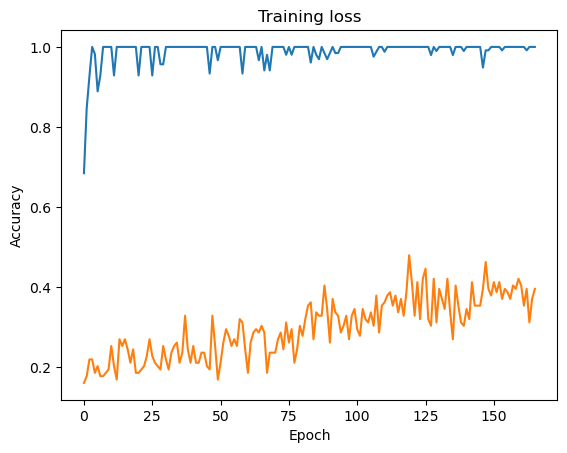

In [13]:
plt.plot(np.array(range(len(target_history["train_acc"]))), target_history["train_acc"])
plt.plot(np.array(range(len(target_history["val_acc"]))), target_history["val_acc"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training loss")
plt.show()

  0%|          | 0/60 [00:00<?, ?it/s]

                  precision    recall  f1-score   support

       back_pack       0.60      0.60      0.60         5
            bike       0.00      0.00      0.00         2
     bike_helmet       1.00      0.75      0.86         4
        bookcase       0.12      1.00      0.22         1
          bottle       0.00      0.00      0.00         2
      calculator       0.40      1.00      0.57         4
      desk_chair       0.00      0.00      0.00        10
       desk_lamp       0.00      0.00      0.00         5
desktop_computer       0.00      0.00      0.00         2
    file_cabinet       0.75      1.00      0.86         3
      headphones       0.40      0.50      0.44         4
        keyboard       0.00      0.00      0.00         1
 laptop_computer       0.00      0.00      0.00         5
     letter_tray       0.00      0.00      0.00         2
    mobile_phone       0.50      0.20      0.29         5
         monitor       0.00      0.00      0.00         6
           mo

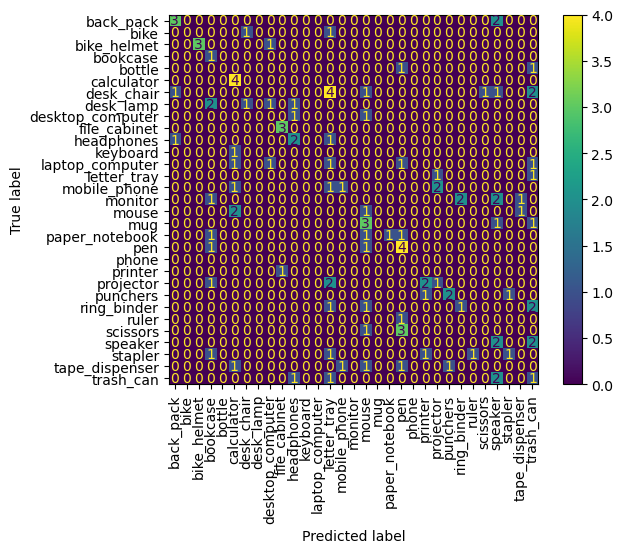

In [14]:
tasks.results.classification_results(model, target_test_loader, class_names, device)

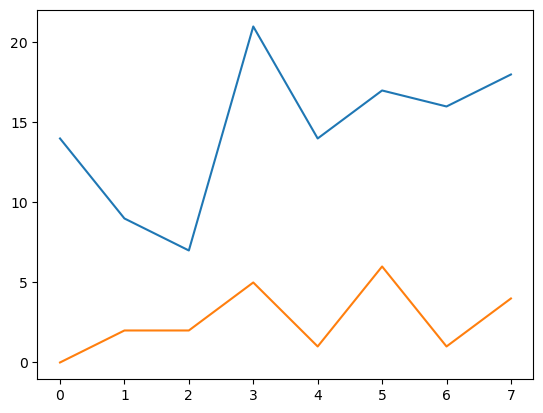

In [16]:
tasks.results.plot_label_history(label_history, encodings)

## Semi-supervised domain adaptation

In [ ]:
if FINETUNE_SEMI_SUPERVISED_MODEL:
    model, history = lib.torch_train_eval.train_model(
        model=model,
        criterion=criterion,
        optimizer=optimizer_ft,
        scheduler=exp_lr_scheduler,
        device=device,
        train_dataloader=tasks.preprocessing.create_padded_dataloader(
            labeled_dataset, shuffle=True, batch_size=BATCH_SIZE
        ),
        val_dataloader=source_val_loader,
        output_dir=SEMI_SUPERVISED_FINETUNED_MODEL_DIR,
        num_epochs=25,
        patience=5,
        warmup_period=5,
        previous_history=history,
    )

model = tasks.utils.try_load_weights(
    model, os.path.join(SEMI_SUPERVISED_FINETUNED_MODEL_DIR, "model.pt")
)

In [ ]:
tasks.results.classification_results(model, target_test_loader, class_names, device)

In [ ]:
if TRAIN_SEMI_SUPERVISED_MODEL:
    model, source_history, target_history, label_history = (
        lib.adaptive_train_eval.train_adaptive_model(
            model=model,
            criterion=criterion,
            optimizer=optimizer_ft,
            scheduler=exp_lr_scheduler,
            device=device,
            source_train_dataset=labeled_dataset,
            source_val_dataset=source_val_dataset,
            labeled_dataloader_initializer=lambda dataset, sampler=None: tasks.preprocessing.create_padded_dataloader(
                dataset, sampler=sampler, batch_size=BATCH_SIZE
            ),
            unlabeled_dataloader_initializer=lambda dataset: torch.utils.data.DataLoader(
                dataset, batch_size=1, shuffle=True
            ),
            unlabeled_target_train_dataset=unlabeled_dataset,
            target_val_dataset=target_val_dataset,
            output_dir=SEMI_SUPERVISED_ADAPTIVE_MODEL_DIR,
            num_epochs=160,
            pseudo_sample_period=20,
            rho=4,
            previous_source_history=source_history,
            previous_target_history=target_history,
        )
    )

model = tasks.utils.try_load_weights(
    model, os.path.join(SEMI_SUPERVISED_ADAPTIVE_MODEL_DIR, "model.pt")
)

In [ ]:
tasks.results.classification_results(model, target_test_loader, class_names, device)

In [ ]:
tasks.results.plot_label_history(label_history, encodings)

## Dustbin